In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import pandasql as sql
import os
import math
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from functools import reduce
from scipy import stats
from sklearn.neighbors import KDTree

In [204]:
from pysal.lib.cg import KDTree as GeodesicKDTree, RADIUS_EARTH_KM

C:\ProgramData\AnacondaInstall\lib\site-packages\pysal\lib\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')


In [303]:
df = pd.read_csv(r"C:\Users\NImi Jithin\Desktop\Studies\sem-3\research track\AggregateMessurement\final2.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,Measured_order,Measurement_file,Month,Day,Year,Start_Time,End_Time,Duration,Duration_in_hours,Duration_in_minutes,Agg_Velocity,Agg_Temp,Predicted_Seg
0,0,0,0.0,m26.csv,August,Tuesday,2018,2018-08-07 16:42:03.752722,2018-08-07 16:42:34.252728,0 days 00:00:30.500006000,0.008472,0.508333,2.780367,34.5,6512.0
1,1,1,1.0,m26.csv,August,Tuesday,2018,2018-08-07 16:42:34.252728,2018-08-07 16:42:35.252723,0 days 00:00:00.999995000,0.000278,0.016667,10.794761,34.5,6513.0
2,2,2,2.0,m26.csv,August,Tuesday,2018,2018-08-07 16:42:35.252723,2018-08-07 16:42:35.752720,0 days 00:00:00.499997000,0.000139,0.008333,8.137900,34.5,6515.0
3,3,3,3.0,m26.csv,August,Tuesday,2018,2018-08-07 16:42:35.752720,2018-08-07 16:42:36.252717,0 days 00:00:00.499997000,0.000139,0.008333,6.038901,34.5,6521.0
4,4,4,4.0,m26.csv,August,Tuesday,2018,2018-08-07 16:42:36.252717,2018-08-07 16:42:37.752729,0 days 00:00:01.500012000,0.000417,0.025000,5.113185,34.5,6524.0


In [304]:
df[['Measurement_file','allele']] = df['Measurement_file'].str.split('.',expand=True)
df[['Measurement_file','Measurement_file']] = df['Measurement_file'].str.split('m',expand=True)
del df['allele']
df['Measurement_file'] = df['Measurement_file'].astype(int)

In [305]:
# converting to to_datetime
df['End_Time'] = pd.to_datetime(df.End_Time)
df['Start_Time'] = pd.to_datetime(df.Start_Time)

df['Datetime'] = pd.to_datetime(df['Start_Time'])
df = df.set_index('Datetime')

In [247]:
df.dtypes

Unnamed: 0                      int64
Unnamed: 0.1                    int64
Measured_order                float64
Measurement_file                int32
Month                          object
Day                            object
Year                            int64
Start_Time             datetime64[ns]
End_Time               datetime64[ns]
Duration                       object
Duration_in_hours             float64
Duration_in_minutes           float64
Agg_Velocity                  float64
Agg_Temp                      float64
Predicted_Seg                 float64
dtype: object

In [306]:
# testing a route which started at 13:00. So retrieving all the data between 12:00 - 15:00

 #Case 1
#df = df.between_time('11:00', '17:00')

# #Case 2
# q1 = """ select * from df where Month IN ('November')"""
# df = sql.sqldf(q1, locals())

#Case 3
df = df.between_time('15:00', '17:00')
q1 = """ select * from df where Month IN ('November') and Day ='Tuesday' """
df = sql.sqldf(q1, locals())

#Case 4

# df = df.between_time('11:00', '17:00')
# q1 = """ select * from df where Month IN ('November') and Day ='Tuesday' """
# df = sql.sqldf(q1, locals())


In [307]:
q1 = """ select distinct(Measurement_file),Year from df order by Measurement_file  """
messFiles = sql.sqldf(q1, locals())
messFiles

,Measurement_file,Year
0,4,2017
1,9,2017
2,10,2017
3,44,2017
4,58,2018


In [250]:
messFiles = messFiles['Measurement_file'].values
messFiles

array([ 4,  9, 10, 44, 58], dtype=int64)

In [251]:
total_len = len(messFiles)
#taking 50% of data for training and 50% for testing
#Calculating testing and trainin data index
train = math.ceil(0.4*total_len)
test =  train+1 #math.floor(0.2*total_len)
print(train,test,total_len)

2 3 5


In [252]:
train = messFiles[0:train+1:1]
test = messFiles[test :total_len:1]
print(train,test)
print(len(train), len(test))

[ 4  9 10] [44 58]
3 2


In [253]:
# dividing the data into test and  as training set
trainingDf = df[df['Measurement_file'].isin(train)]
testDf = df[df['Measurement_file'].isin(test)]
print(len(trainingDf),len(testDf))

2329 1669


In [280]:
testRoute = 'C:/Users/NImi Jithin/Desktop/Studies/sem-3/research track/AggregateMessurement/tempDf.csv'
testRouteDF = pd.read_csv(testRoute)

In [300]:
testRouteDF['TimeStamp'] = pd.to_datetime(testRouteDF.TimeStamp)
testRouteDF['Time_Seg'] = pd.to_datetime(testRouteDF.Time_Seg)

In [302]:
testRouteDF.dtypes

Unnamed: 0                int64
TimeStamp        datetime64[ns]
Predicted_Seg           float64
Seg_length              float64
Time_Seg         datetime64[ns]
DwellTime               float64
HH:MM:SS                 object
dtype: object

In [281]:
x = reduce(np.intersect1d, (testDf.Predicted_Seg, testRouteDF.Predicted_Seg, trainingDf.Predicted_Seg))
len(x)

551

In [282]:
trainingDf = trainingDf[trainingDf['Predicted_Seg'].isin(x)]
testDf = testDf[testDf['Predicted_Seg'].isin(x)]

In [283]:
test_route_seg_ids = x
len(test_route_seg_ids)

551

In [284]:
df = pd.read_excel("C:/Users/NImi Jithin/Desktop/data/measurements/SegmentTable.xlsx")

In [285]:
df.head()

,Segment_ID,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude,Segment_Length,Mid_Latitude,Mid_Longitude
0,1,10.128375,51.868551,10.128433,51.868380,0.019427,51.868466,10.128404
1,2,10.128384,51.868665,10.128375,51.868551,0.012691,51.868608,10.128379
2,3,10.128433,51.868380,10.128498,51.868291,0.010856,51.868336,10.128466
3,4,10.128443,51.885236,10.128478,51.884912,0.036107,51.885074,10.128461
4,5,10.128471,51.885496,10.128443,51.885236,0.028975,51.885366,10.128457


In [286]:
def getLatLong(seg_id):
    
    source_latlon_df = df.loc[df['Segment_ID'] == seg_id]
    source_latlon = source_latlon_df[['Mid_Latitude', 'Mid_Longitude']].values
    return source_latlon

In [287]:
target_latlons = df[['Mid_Latitude', 'Mid_Longitude']].values

In [288]:
target_tree = GeodesicKDTree(target_latlons, distance_metric='Arc', radius=RADIUS_EARTH_KM * 1000)

In [289]:
#tree = KDTree(target_latlons, leaf_size=2) 

In [291]:
tempDf = pd.DataFrame({'TimeStamp': [],'Predicted_Seg': [], 'Seg_length':[], 'Time_Seg':[], 
                       'DwellTime': [], 'HH:MM:SS':[], 'Neighbour':[], 'Distances':[]})

In [292]:
tempDf.head()

,TimeStamp,Predicted_Seg,Seg_length,Time_Seg,DwellTime,HH:MM:SS,Neighbour,Distances


In [295]:
testRouteDF.head()

,Unnamed: 0,TimeStamp,Predicted_Seg,Seg_length,Time_Seg,DwellTime,HH:MM:SS
0,0,1900-01-01 13:00:00,6588.0,0.010098,1900-01-01 13:00:05,0.088889,0 days 00:00:05.000000000
1,1,1900-01-01 13:00:05,6598.0,0.001314,1900-01-01 13:00:05,0.041667,0 days 00:00:02.000000000
2,2,1900-01-01 13:00:07,6599.0,0.032159,1900-01-01 13:00:07,0.050000,0 days 00:00:02.000000000
3,3,1900-01-01 13:00:09,6613.0,0.021411,1900-01-01 13:00:09,0.033333,0 days 00:00:01.000000000
4,4,1900-01-01 13:00:10,6614.0,0.028462,1900-01-01 13:00:10,0.033333,0 days 00:00:01.000000000


In [301]:
for indexMess, rowMess in testRouteDF.iterrows():
    seg_id = rowMess['Predicted_Seg']
    source_latlon = getLatLong(seg_id)
    distances, indices = target_tree.query(source_latlon, k=10)
    print(seg_id, distances, indices)
    
    tempDf = tempDf.append({'TimeStamp': trainingDf.iloc[indexMess]['TimeStamp'],
               'Predicted_Seg':trainingDf.iloc[indexMess]['Predicted_Seg'],
               'Seg_length':trainingDf.iloc[indexMess]['Seg_length'],
               'Time_Seg':trainingDf.iloc[indexMess]['Time_Seg'],
               'DwellTime':trainingDf.iloc[indexMess]['DwellTime'],
               'HH:MM:SS':trainingDf.iloc[indexMess]['HH:MM:SS'],'Distances':distances}, ignore_index=True)


6588.0 [[ 0.          0.          7.2119591   8.24079947 17.99017634 17.99017634
  26.21245926 32.20616145 43.11358806 43.11358806]] [[6587 6596 6605 6597 6584 6586 6598 6612 6578 6585]]


KeyError: 'TimeStamp'

In [297]:
trainingDf.head(3)

,Datetime,Unnamed: 0,Unnamed: 0.1,Measured_order,Measurement_file,Month,Day,Year,Start_Time,End_Time,Duration,Duration_in_hours,Duration_in_minutes,Agg_Velocity,Agg_Temp,Predicted_Seg
11,2017-11-28 16:21:25.652860,62352,62352,11.0,10,November,Tuesday,2017,2017-11-28 16:21:25.652860,2017-11-28 16:21:29.152861,0 days 00:00:03.500001000,0.000972,0.058333,14.899703,4.0,6588.0
37,2017-11-28 16:22:23.652857,62378,62378,37.0,10,November,Tuesday,2017,2017-11-28 16:22:23.652857,2017-11-28 16:22:24.652862,0 days 00:00:01.000005000,0.000278,0.016667,33.992784,4.0,6448.0
39,2017-11-28 16:22:25.652856,62380,62380,39.0,10,November,Tuesday,2017,2017-11-28 16:22:25.652856,2017-11-28 16:22:26.652861,0 days 00:00:01.000005000,0.000278,0.016667,26.147724,4.0,6446.0


In [296]:
q1 = """ select * from trainingDf where  Predicted_Seg in ('6587', '6596', '6605', '6597', '6584', '6586', '6598', '6612', '6578', '6585') """
messFiles = sql.sqldf(q1, locals())
messFiles

,Datetime,Unnamed: 0,Unnamed: 0.1,Measured_order,Measurement_file,Month,Day,Year,Start_Time,End_Time,Duration,Duration_in_hours,Duration_in_minutes,Agg_Velocity,Agg_Temp,Predicted_Seg


In [225]:
trainingDf

,Datetime,Unnamed: 0,Unnamed: 0.1,Measured_order,Measurement_file,Month,Day,Year,Start_Time,End_Time,Duration,Duration_in_hours,Duration_in_minutes,Agg_Velocity,Agg_Temp,Predicted_Seg
0,2017-11-28 16:20:28.152860,62341,62341,0.0,10,November,Tuesday,2017,2017-11-28 16:20:28.152860,2017-11-28 16:20:56.652856,0 days 00:00:28.499996000,0.007917,0.475000,3.652520,4.500000,6512.0
1,2017-11-28 16:20:56.652856,62342,62342,1.0,10,November,Tuesday,2017,2017-11-28 16:20:56.652856,2017-11-28 16:20:58.652855,0 days 00:00:01.999999000,0.000556,0.033333,5.552221,4.500000,6513.0
3,2017-11-28 16:20:59.152863,62344,62344,3.0,10,November,Tuesday,2017,2017-11-28 16:20:59.152863,2017-11-28 16:20:59.652860,0 days 00:00:00.499997000,0.000139,0.008333,5.660881,4.500000,6519.0
5,2017-11-28 16:21:00.652854,62346,62346,5.0,10,November,Tuesday,2017,2017-11-28 16:21:00.652854,2017-11-28 16:21:08.652861,0 days 00:00:08.000007000,0.002222,0.133333,1.995581,4.500000,6524.0
6,2017-11-28 16:21:08.652861,62347,62347,6.0,10,November,Tuesday,2017,2017-11-28 16:21:08.652861,2017-11-28 16:21:11.652855,0 days 00:00:02.999994000,0.000833,0.050000,11.177320,4.500000,6471.0
7,2017-11-28 16:21:11.652855,62348,62348,7.0,10,November,Tuesday,2017,2017-11-28 16:21:11.652855,2017-11-28 16:21:14.152862,0 days 00:00:02.500007000,0.000694,0.041667,20.180769,4.500000,6541.0
8,2017-11-28 16:21:14.152862,62349,62349,8.0,10,November,Tuesday,2017,2017-11-28 16:21:14.152862,2017-11-28 16:21:17.152855,0 days 00:00:02.999993000,0.000833,0.050000,22.708227,4.169354,6551.0
9,2017-11-28 16:21:17.152855,62350,62350,9.0,10,November,Tuesday,2017,2017-11-28 16:21:17.152855,2017-11-28 16:21:20.652857,0 days 00:00:03.500002000,0.000972,0.058333,18.839355,4.000000,6542.0
10,2017-11-28 16:21:20.652857,62351,62351,10.0,10,November,Tuesday,2017,2017-11-28 16:21:20.652857,2017-11-28 16:21:25.652860,0 days 00:00:05.000003000,0.001389,0.083333,17.759022,4.000000,6555.0
11,2017-11-28 16:21:25.652860,62352,62352,11.0,10,November,Tuesday,2017,2017-11-28 16:21:25.652860,2017-11-28 16:21:29.152861,0 days 00:00:03.500001000,0.000972,0.058333,14.899703,4.000000,6588.0


Text(0, 0.5, 'Agg_Velocity in')

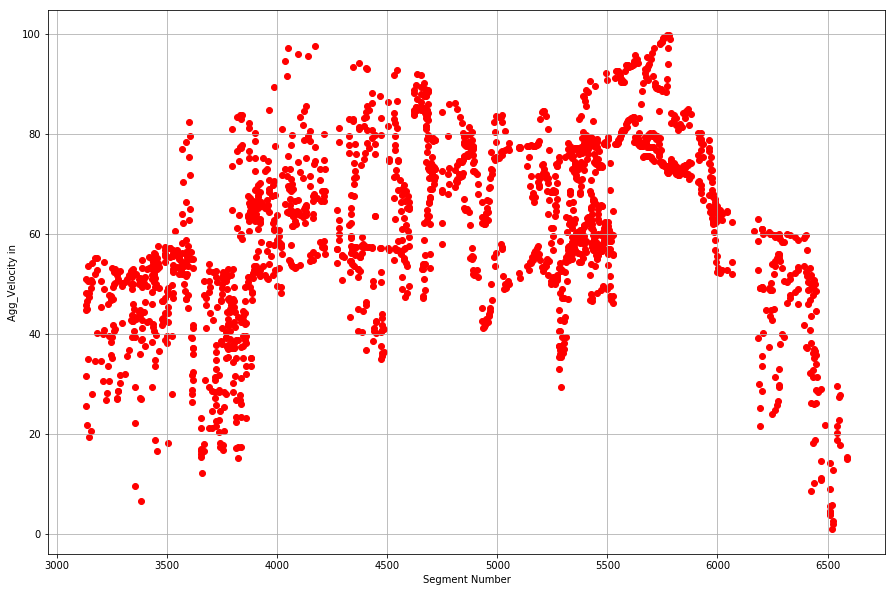

In [243]:
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)
# ax.grid(which='both')
# plt.scatter(trainingDf.Agg_Temp, trainingDf.Predicted_Seg,label= 'Predicted Data',color='red', )
# plt.rcParams["figure.figsize"] = (15,10)
# plt.xlabel('Temp in')
# plt.ylabel('Segment Number')

fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.plot3D(trainingDf.Agg_Velocity,trainingDf.Predicted_Seg,trainingDf.Agg_Temp)
ax = fig.add_subplot(1, 1, 1)
ax.grid(which='both')
plt.scatter(trainingDf.Predicted_Seg, trainingDf.Agg_Velocity,label= 'Predicted Data',color='red', )
plt.rcParams["figure.figsize"] = (15,10)
plt.xlabel('Segment Number')
plt.ylabel('Agg_Velocity in')


In [24]:
#tree = KDTree(trainingDf, leaf_size=2)
#sample= trainingDf.to_numpy()

In [41]:
#tree = KDTree(sample, leaf_size=2)
del trainingDf['Duration']

In [44]:
trainingDf.dtypes

Datetime                object
Unnamed: 0               int64
Unnamed: 0.1             int64
Measured_order         float64
Measurement_file         int64
Month                   object
Day                     object
Year                     int64
Start_Time              object
End_Time                object
Duration_in_hours      float64
Duration_in_minutes    float64
Agg_Velocity           float64
Agg_Temp               float64
Predicted_Seg          float64
dtype: object

In [43]:
tree = KDTree(trainingDf, leaf_size=2)

ValueError: could not convert string to float: '2017-11-28 15:20:05.276443'